# Trening generator + diskriminator

In [64]:
import os
from PIL import Image
import numpy as np
from skimage import color
import torch
from skimage.color import lab2rgb
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from generator import Generator
from discriminator import Discriminator
from BaseColor import *

In [65]:

def find_images_recursive(folder, extensions=('.JPEG', '.jpeg', '.jpg', '.JPG')):
    img_paths = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(extensions):
                img_paths.append(os.path.abspath(os.path.join(root, f)))
    return img_paths


In [66]:
class ColorizationDataset(Dataset, BaseColor):
    def __init__(self, root_dir, HW=(256, 256), extensions=('.JPEG', '.jpeg', '.jpg', '.JPG')):
        Dataset.__init__(self)
        BaseColor.__init__(self)
        self.HW = HW
        self.img_paths = find_images_recursive(root_dir, extensions)
        print(f"Pronađeno {len(self.img_paths)} slika u {root_dir} i podfolderima.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        try:
            # img_rgb_orig = load_img(img_path)

            # tens_l, tens_ab = preprocess_img(img_rgb_orig, HW=self.HW)

            # return tens_l, tens_ab
            img_rgb_orig = load_img(img_path)

            tens_orig_l, tens_rs_l = preprocess_img(img_rgb_orig, HW=self.HW)

            img_rgb_rs = resize_img(img_rgb_orig, HW=self.HW, resample=Image.BILINEAR)
            img_lab_rs = color.rgb2lab(img_rgb_rs).astype(np.float32)

            img_ab_rs = img_lab_rs[:, :, 1:3]
            tens_ab = torch.tensor(img_ab_rs).permute(2,0,1).float()

            tens_l_norm = self.normalize_l(tens_rs_l.squeeze(0))
            tens_ab_norm = self.normalize_ab(tens_ab)

            return tens_l_norm, tens_ab_norm

        except Exception as e:
            print(f"Preskačem fajl zbog greške: {img_path}\nGreška: {e}")
            return self.__getitem__((idx + 1) % len(self))


In [67]:
dataset = ColorizationDataset("images_pfe/8/train.X1/n01440764", HW=(256, 256))
# input_l, target_ab = dataset[0]

Pronađeno 1300 slika u images_pfe/8/train.X1/n01440764 i podfolderima.


In [68]:
target_ab.shape, input_l.shape

(torch.Size([1, 1, 4, 2, 256, 256]), torch.Size([1, 1, 4, 1, 256, 256]))

In [52]:
input_l

tensor([[[[[-0.4665, -0.4847, -0.4482,  ..., -0.0611, -0.1106, -0.1891],
           [-0.4742, -0.4824, -0.4777,  ..., -0.1099, -0.0739, -0.1388],
           [-0.4638, -0.4785, -0.4763,  ..., -0.2412, -0.1353, -0.1806],
           ...,
           [-0.1285, -0.0652, -0.0706,  ..., -0.2091,  0.0027, -0.3141],
           [-0.1368, -0.1517, -0.1559,  ..., -0.1162, -0.1374,  0.0155],
           [-0.1368, -0.1898, -0.1517,  ..., -0.1132, -0.1533, -0.1164]]],


         [[[-0.1693, -0.3463,  0.0287,  ...,  0.3784,  0.4597,  0.4637],
           [-0.0470, -0.2156, -0.0822,  ...,  0.4328,  0.4835,  0.4923],
           [-0.0431, -0.1485,  0.0053,  ...,  0.4859,  0.4695,  0.3263],
           ...,
           [ 0.2358,  0.2175,  0.1693,  ..., -0.0548, -0.0342,  0.3252],
           [ 0.1184,  0.2116,  0.2337,  ..., -0.0971, -0.0130,  0.2501],
           [ 0.1222,  0.2116,  0.2300,  ..., -0.2184,  0.1053, -0.0034]]],


         [[[ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
           

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
num_epochs = 10
learning_rate = 1e-3
HW = (256, 256) 


In [70]:

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.Adam(generator.parameters(), learning_rate, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), learning_rate, betas=(0.5, 0.999))


In [71]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Funkcije

In [72]:
def numpy_to_tensor(np_img):
    if isinstance(np_img, np.ndarray):
        tensor = torch.from_numpy(np_img.astype(np.float32))
        if tensor.ndim == 3:
            tensor = tensor.permute(2, 0, 1)
        elif tensor.ndim == 4:
            tensor = tensor.permute(0, 3, 1, 2)
        return tensor
    else:
        raise TypeError("Ulaz nije NumPy niz")
    
def lab_to_rgb_image(input_l, out_ab):
    base_color = BaseColor()
    l_denorm = base_color.unnormalize_l(input_l)
    ab_denorm = base_color.unnormalize_ab(out_ab)

    lab = torch.cat([l_denorm, ab_denorm], dim=1)
    lab_np = lab[0].permute(1, 2, 0).cpu().numpy()

    rgb = lab2rgb(lab_np)
    return rgb

def safe_lab2rgb(lab):
    lab_clipped = lab.copy()
    lab_clipped[..., 0] = np.clip(lab_clipped[..., 0], 0, 100)     
    lab_clipped[..., 1] = np.clip(lab_clipped[..., 1], -110, 110)  
    lab_clipped[..., 2] = np.clip(lab_clipped[..., 2], -110, 110)  

    rgb = lab2rgb(lab_clipped)
    return rgb

def show_images(real, fake):
    real = real.permute(1, 2, 0).detach().cpu().numpy()
    fake = fake.permute(1, 2, 0).detach().cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(real)
    axs[0].set_title("Originalna slika")
    axs[0].axis('off')

    axs[1].imshow(fake)
    axs[1].set_title("Generisana slika")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Checkpoint

In [73]:
start_epoch = 0
checkpoint_path = 'checkpoint.pth1'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    gen_opt.load_state_dict(checkpoint['optimizer_g_dict'])
    disc_opt.load_state_dict(checkpoint['optimizer_d_dict'])
    start_epoch = checkpoint['epoch'] + 1
    global_step = checkpoint.get('global_step', 0)
    print(f"Nastavljam od epohe {start_epoch}, global_step = {global_step}")
else:
    global_step = 0

# Generator loss

In [74]:
bce_loss = nn.BCEWithLogitsLoss()
LAMBDA = 100

def delta_e_loss(input_l, ab_pred, ab_true):
    base_color = BaseColor()
    # l_denorm = base_color.unnormalize_l(input_l)
    # ab_pred_denorm = base_color.unnormalize_ab(ab_pred)
    # ab_true_denorm = base_color.unnormalize_ab(ab_true)

    # lab_pred = torch.cat([l_denorm, ab_pred_denorm], dim=1)
    # lab_true = torch.cat([l_denorm, ab_true_denorm], dim=1)

    delta_e = torch.norm(ab_pred - ab_true, dim=1)  
    return delta_e.mean()

def colorfulness_loss(ab_pred):
    return -ab_pred.abs().mean()

def gan_loss(disc_generated_output):
    gan_loss = bce_loss(torch.ones_like(disc_generated_output), disc_generated_output)
    return gan_loss

def generator_loss(input_l,ab_pred,ab_true,disc_generated_output):
    color_loss = delta_e_loss(input_l, ab_pred, ab_true)
    boost_color = colorfulness_loss(ab_pred)
    gan_total_loss = gan_loss(disc_generated_output)
    loss = color_loss + 0.1 * boost_color + gan_total_loss
    return loss


# Diskriminator loss

In [75]:
bce_loss = nn.BCEWithLogitsLoss()
LAMBDA = 100

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = bce_loss(disc_real_output, torch.ones_like(disc_real_output))
    fake_loss = bce_loss(disc_generated_output, torch.zeros_like(disc_generated_output))
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss

# Provere neke

In [60]:
input_l.max(),input_l.min(),target_ab.max(),target_ab.min()

(tensor(0.5000), tensor(-0.5000), tensor(0.7054), tensor(-0.3905))

In [61]:
input_l.shape,target_ab.shape

(torch.Size([1, 4, 1, 256, 256]), torch.Size([1, 4, 2, 256, 256]))

In [62]:
input_l = input_l.unsqueeze(0)    # (1, 1, 256, 256)
target_ab = target_ab.unsqueeze(0)                # (1, 2, 256, 256)
input_l.shape, target_ab.shape

(torch.Size([1, 1, 4, 1, 256, 256]), torch.Size([1, 1, 4, 2, 256, 256]))

In [63]:

input_l = input_l.to(device)        
target_ab = target_ab.to(device)
fake_ab = generator(input_l)


KeyboardInterrupt



In [ ]:
fake_ab.shape

torch.Size([1, 2, 256, 256])

In [ ]:
fake_ab.max(),fake_ab.min()

(tensor(0.1463, grad_fn=<MaxBackward1>),
 tensor(-0.1693, grad_fn=<MinBackward1>))

In [ ]:
fake_lab = torch.cat([input_l, fake_ab], dim=1) 
real_lab = torch.cat([input_l, target_ab], dim=1)
input_rgb = input_l.repeat(1, 3, 1, 1)  

In [ ]:
fake_lab.shape,real_lab.shape,input_rgb.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]))

In [ ]:

        
disc_real_out = discriminator(input_rgb, real_lab)
disc_fake_out = discriminator(input_rgb, fake_lab.detach())


In [ ]:
disc_fake_out.shape, disc_real_out.min()

(torch.Size([1, 30, 30]), tensor(-0.9526, grad_fn=<MinBackward1>))

In [ ]:
loss = discriminator_loss(disc_real_out, disc_fake_out)
loss

tensor(1.4242, grad_fn=<AddBackward0>)

In [ ]:
dataloader

In [ ]:
# 1) Да ли Dataset уопште има слике?
print("UKUPNO:", len(dataset))

# 2) Пробајте да ручно дохватите један пример
sample = dataset[0]          # овде би грешка морала да се јави ако постоји
print([t.shape for t in sample])

# 3) DataLoader без радника
dataloader = DataLoader(dataset,
                        batch_size=4,
                        shuffle=True,
                        num_workers=0,   # ⇐
                        pin_memory=False)

for b, (l, ab) in enumerate(dataloader):
    print("batch", b, l.shape, ab.shape)
    if b == 2: break


UKUPNO: 1300
[torch.Size([1, 256, 256]), torch.Size([2, 256, 256])]
batch 0 torch.Size([4, 1, 256, 256]) torch.Size([4, 2, 256, 256])
batch 1 torch.Size([4, 1, 256, 256]) torch.Size([4, 2, 256, 256])
batch 2 torch.Size([4, 1, 256, 256]) torch.Size([4, 2, 256, 256])


In [ ]:
from tqdm import tqdm

for i, data in tqdm(enumerate(dataloader)):
    if i == 5:
        break  # testiraj prvih par iteracija


c:\Users\PFE\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


# Potpun trening


===== Epoha 1/10 =====
-- Batch 1/325


C:\Users\PFE\AppData\Local\Temp\ipykernel_11460\1421274264.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab_np)


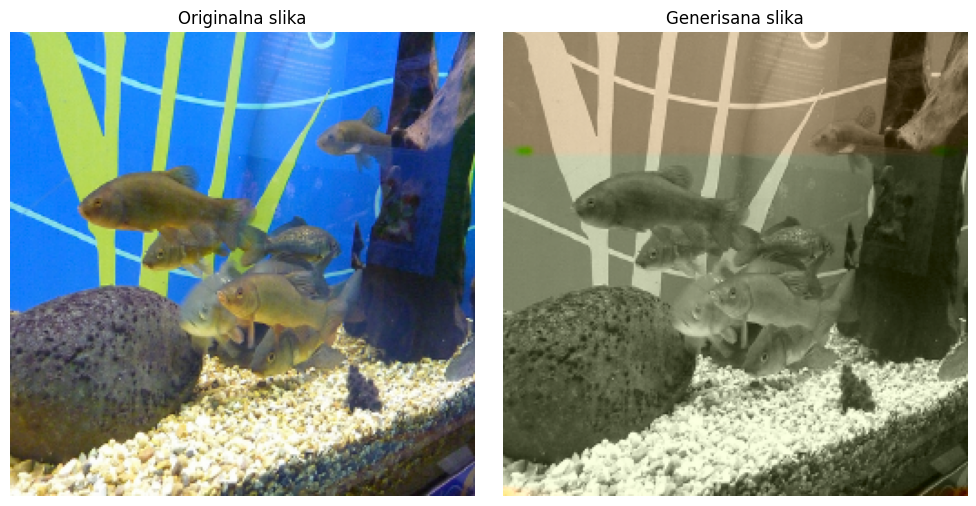

Gen Loss: 1.4234, Disc Loss: 1.4493, GAN: 1.4234
-- Batch 2/325
-- Batch 3/325
-- Batch 4/325
-- Batch 5/325
-- Batch 6/325
-- Batch 7/325
-- Batch 8/325
-- Batch 9/325
-- Batch 10/325
-- Batch 11/325
-- Batch 12/325
-- Batch 13/325
-- Batch 14/325
-- Batch 15/325
-- Batch 16/325
-- Batch 17/325
-- Batch 18/325
-- Batch 19/325
-- Batch 20/325
-- Batch 21/325
-- Batch 22/325
-- Batch 23/325
-- Batch 24/325
-- Batch 25/325
-- Batch 26/325
-- Batch 27/325
-- Batch 28/325
-- Batch 29/325
-- Batch 30/325
-- Batch 31/325
-- Batch 32/325
-- Batch 33/325
-- Batch 34/325
-- Batch 35/325
-- Batch 36/325
-- Batch 37/325
-- Batch 38/325
-- Batch 39/325
-- Batch 40/325
-- Batch 41/325
-- Batch 42/325
-- Batch 43/325
-- Batch 44/325
-- Batch 45/325
-- Batch 46/325
-- Batch 47/325
-- Batch 48/325
-- Batch 49/325
-- Batch 50/325
-- Batch 51/325
-- Batch 52/325
-- Batch 53/325
-- Batch 54/325
-- Batch 55/325
-- Batch 56/325
-- Batch 57/325
-- Batch 58/325
-- Batch 59/325
-- Batch 60/325
-- Batch 61/325

C:\Users\PFE\AppData\Local\Temp\ipykernel_11460\1421274264.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 143 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab_np)


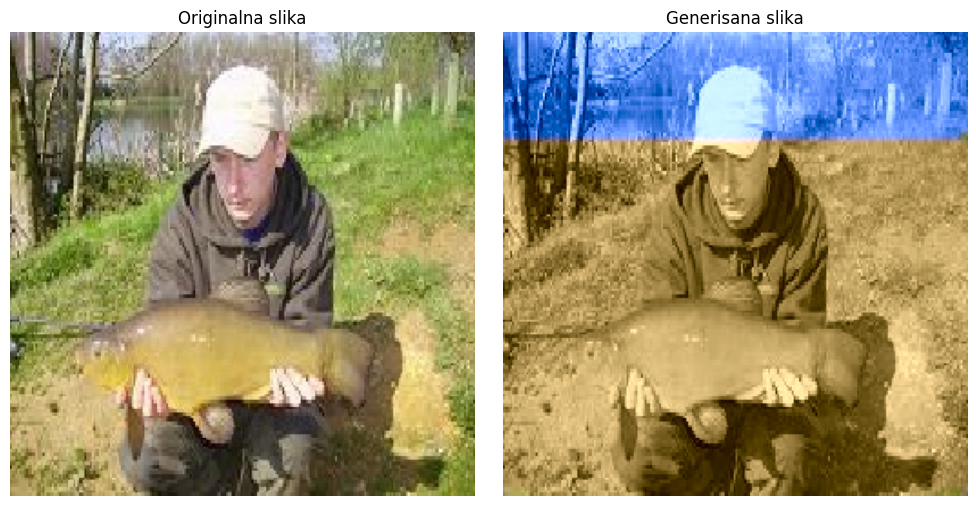

Gen Loss: 1.9129, Disc Loss: 1.3367, GAN: 1.9129
-- Batch 102/325
-- Batch 103/325
-- Batch 104/325
-- Batch 105/325
-- Batch 106/325
-- Batch 107/325
-- Batch 108/325
-- Batch 109/325
-- Batch 110/325
-- Batch 111/325
-- Batch 112/325
-- Batch 113/325
-- Batch 114/325
-- Batch 115/325
-- Batch 116/325
-- Batch 117/325
-- Batch 118/325
-- Batch 119/325
-- Batch 120/325
-- Batch 121/325
-- Batch 122/325
-- Batch 123/325
-- Batch 124/325
-- Batch 125/325
-- Batch 126/325
-- Batch 127/325
-- Batch 128/325
-- Batch 129/325
-- Batch 130/325
-- Batch 131/325
-- Batch 132/325
-- Batch 133/325
-- Batch 134/325
-- Batch 135/325
-- Batch 136/325
-- Batch 137/325
-- Batch 138/325
-- Batch 139/325
-- Batch 140/325
-- Batch 141/325
-- Batch 142/325
-- Batch 143/325
-- Batch 144/325
-- Batch 145/325
-- Batch 146/325
-- Batch 147/325
-- Batch 148/325
-- Batch 149/325
-- Batch 150/325
-- Batch 151/325
-- Batch 152/325
-- Batch 153/325
-- Batch 154/325
-- Batch 155/325
-- Batch 156/325
-- Batch 157/325

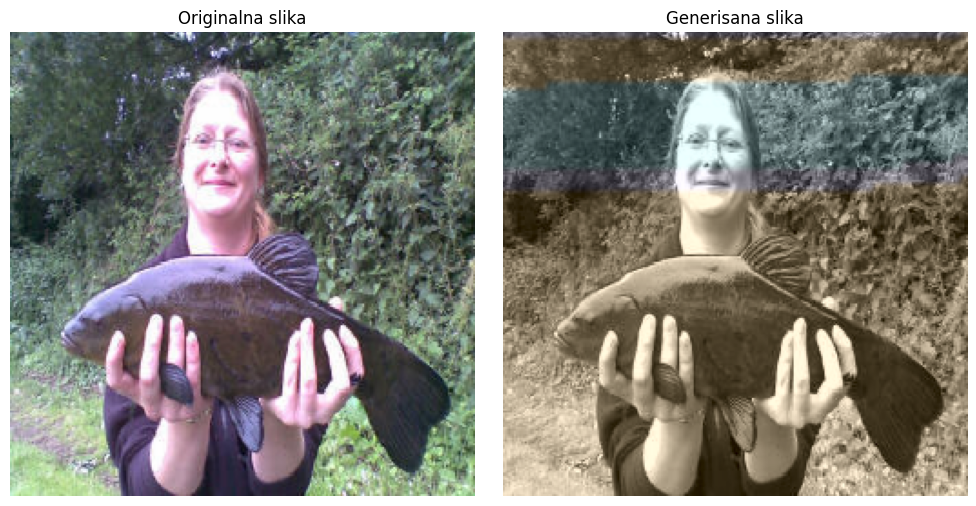

Gen Loss: 2.1339, Disc Loss: 1.2967, GAN: 2.1339
-- Batch 202/325
-- Batch 203/325
-- Batch 204/325
-- Batch 205/325
-- Batch 206/325
-- Batch 207/325
-- Batch 208/325
-- Batch 209/325
-- Batch 210/325
-- Batch 211/325
-- Batch 212/325
-- Batch 213/325
-- Batch 214/325
-- Batch 215/325
-- Batch 216/325
-- Batch 217/325
-- Batch 218/325
-- Batch 219/325
-- Batch 220/325
-- Batch 221/325
-- Batch 222/325
-- Batch 223/325
-- Batch 224/325
-- Batch 225/325
-- Batch 226/325
-- Batch 227/325
-- Batch 228/325
-- Batch 229/325
-- Batch 230/325
-- Batch 231/325
-- Batch 232/325
-- Batch 233/325
-- Batch 234/325
-- Batch 235/325
-- Batch 236/325
-- Batch 237/325
-- Batch 238/325
-- Batch 239/325
-- Batch 240/325
-- Batch 241/325
-- Batch 242/325
-- Batch 243/325
-- Batch 244/325
-- Batch 245/325
-- Batch 246/325
-- Batch 247/325
-- Batch 248/325
-- Batch 249/325
-- Batch 250/325
-- Batch 251/325
-- Batch 252/325
-- Batch 253/325
-- Batch 254/325
-- Batch 255/325
-- Batch 256/325
-- Batch 257/325

C:\Users\PFE\AppData\Local\Temp\ipykernel_11460\1421274264.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 501 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab_np)


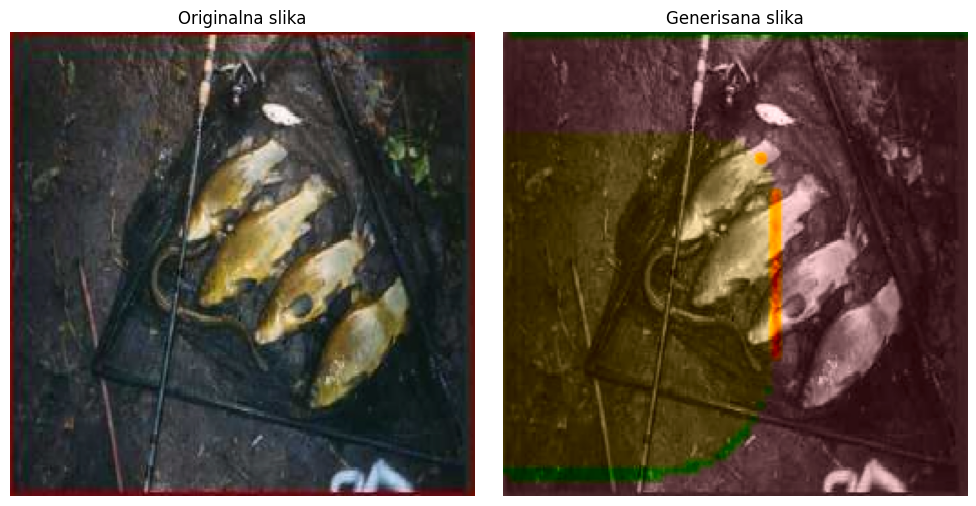

Gen Loss: 2.4822, Disc Loss: 1.3361, GAN: 2.4822
-- Batch 302/325
-- Batch 303/325
-- Batch 304/325
-- Batch 305/325
-- Batch 306/325
-- Batch 307/325
-- Batch 308/325
-- Batch 309/325
-- Batch 310/325
-- Batch 311/325
-- Batch 312/325
-- Batch 313/325
-- Batch 314/325
-- Batch 315/325
-- Batch 316/325
-- Batch 317/325
-- Batch 318/325
-- Batch 319/325
-- Batch 320/325
-- Batch 321/325
-- Batch 322/325
-- Batch 323/325
-- Batch 324/325
-- Batch 325/325
Epoch 1 završena. G-Loss: 1.9726, D-Loss: 1.3550. Vreme: 7057.3 s

===== Epoha 2/10 =====
-- Batch 1/325
-- Batch 2/325
-- Batch 3/325
-- Batch 4/325
-- Batch 5/325
-- Batch 6/325
-- Batch 7/325
-- Batch 8/325
-- Batch 9/325
-- Batch 10/325
-- Batch 11/325
-- Batch 12/325
-- Batch 13/325
-- Batch 14/325
-- Batch 15/325
-- Batch 16/325
-- Batch 17/325
-- Batch 18/325
-- Batch 19/325
-- Batch 20/325
-- Batch 21/325
-- Batch 22/325
-- Batch 23/325
-- Batch 24/325
-- Batch 25/325
-- Batch 26/325
-- Batch 27/325
-- Batch 28/325
-- Batch 29/32

C:\Users\PFE\AppData\Local\Temp\ipykernel_11460\1421274264.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 385 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab_np)


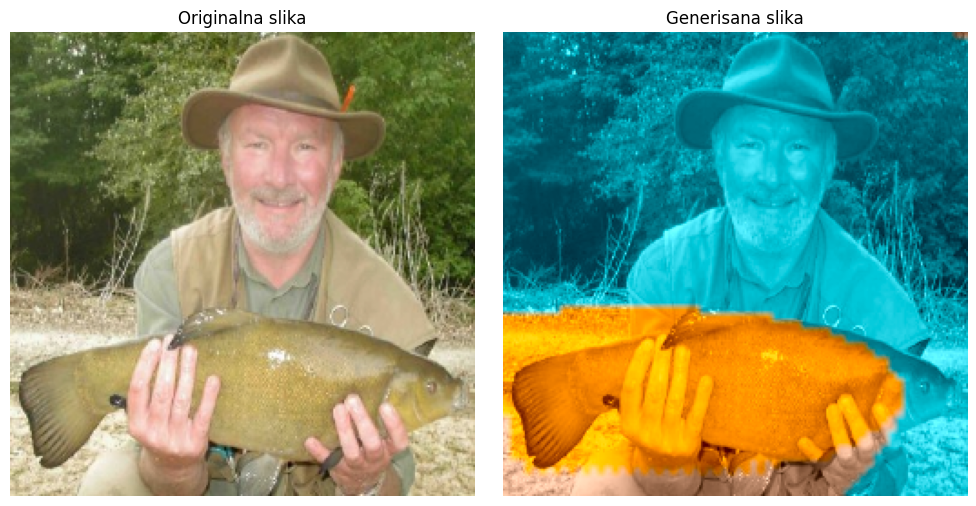

Gen Loss: 3.6141, Disc Loss: 0.9614, GAN: 3.6141
-- Batch 77/325
-- Batch 78/325
-- Batch 79/325
-- Batch 80/325
-- Batch 81/325
-- Batch 82/325
-- Batch 83/325
-- Batch 84/325
-- Batch 85/325
-- Batch 86/325
-- Batch 87/325
-- Batch 88/325
-- Batch 89/325
-- Batch 90/325
-- Batch 91/325
-- Batch 92/325
-- Batch 93/325
-- Batch 94/325
-- Batch 95/325
-- Batch 96/325
-- Batch 97/325
-- Batch 98/325
-- Batch 99/325
-- Batch 100/325
-- Batch 101/325
-- Batch 102/325
-- Batch 103/325
-- Batch 104/325
-- Batch 105/325
-- Batch 106/325
-- Batch 107/325
-- Batch 108/325
-- Batch 109/325
-- Batch 110/325
-- Batch 111/325
-- Batch 112/325
-- Batch 113/325
-- Batch 114/325
-- Batch 115/325
-- Batch 116/325
-- Batch 117/325
-- Batch 118/325
-- Batch 119/325
-- Batch 120/325
-- Batch 121/325
-- Batch 122/325
-- Batch 123/325
-- Batch 124/325
-- Batch 125/325
-- Batch 126/325
-- Batch 127/325
-- Batch 128/325
-- Batch 129/325
-- Batch 130/325
-- Batch 131/325
-- Batch 132/325
-- Batch 133/325
-- Ba

C:\Users\PFE\AppData\Local\Temp\ipykernel_11460\1421274264.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8676 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab_np)


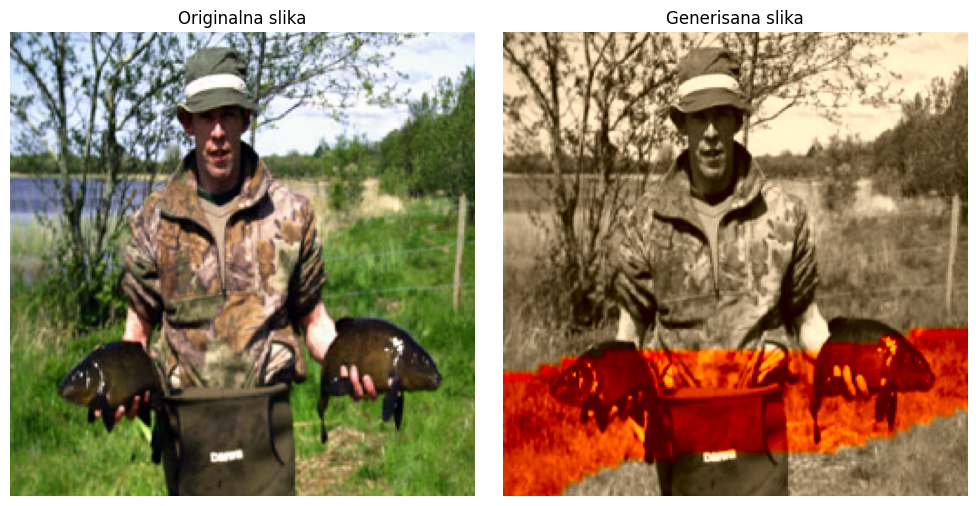

Gen Loss: 4.5008, Disc Loss: 0.1846, GAN: 4.5008
-- Batch 177/325
-- Batch 178/325
-- Batch 179/325
-- Batch 180/325
-- Batch 181/325
-- Batch 182/325
-- Batch 183/325
-- Batch 184/325
-- Batch 185/325
-- Batch 186/325
-- Batch 187/325
-- Batch 188/325
-- Batch 189/325
-- Batch 190/325
-- Batch 191/325
-- Batch 192/325
-- Batch 193/325
-- Batch 194/325
-- Batch 195/325
-- Batch 196/325
-- Batch 197/325
-- Batch 198/325
-- Batch 199/325
-- Batch 200/325
-- Batch 201/325
-- Batch 202/325
-- Batch 203/325
-- Batch 204/325
-- Batch 205/325
-- Batch 206/325
-- Batch 207/325
-- Batch 208/325
-- Batch 209/325
-- Batch 210/325
-- Batch 211/325
-- Batch 212/325
-- Batch 213/325
-- Batch 214/325
-- Batch 215/325
-- Batch 216/325
-- Batch 217/325
-- Batch 218/325
-- Batch 219/325
-- Batch 220/325
-- Batch 221/325
-- Batch 222/325
-- Batch 223/325
-- Batch 224/325
-- Batch 225/325
-- Batch 226/325
-- Batch 227/325
-- Batch 228/325
-- Batch 229/325
-- Batch 230/325
-- Batch 231/325
-- Batch 232/325

C:\Users\PFE\AppData\Local\Temp\ipykernel_11460\1421274264.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3783 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab_np)


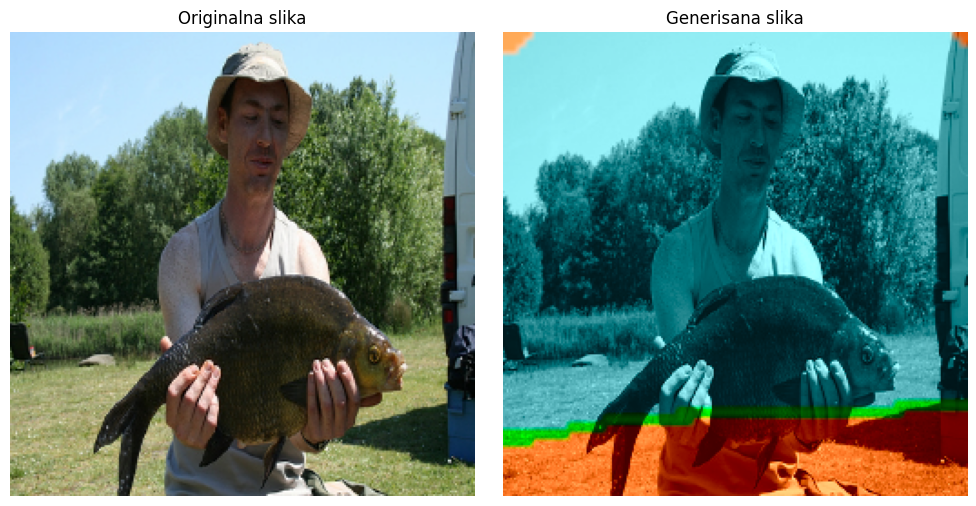

Gen Loss: 5.9032, Disc Loss: 0.1870, GAN: 5.9032
-- Batch 277/325
-- Batch 278/325
-- Batch 279/325
-- Batch 280/325
-- Batch 281/325
-- Batch 282/325
-- Batch 283/325
-- Batch 284/325
-- Batch 285/325
-- Batch 286/325
-- Batch 287/325
-- Batch 288/325
-- Batch 289/325
-- Batch 290/325
-- Batch 291/325
-- Batch 292/325
-- Batch 293/325
-- Batch 294/325
-- Batch 295/325
-- Batch 296/325
-- Batch 297/325


KeyboardInterrupt: 

In [77]:
import warnings
import matplotlib.pyplot as plt

# warnings.filterwarnings("ignore", message="Conversion from CIE-LAB, via XYZ to sRGB color space resulted in .* negative Z values.*")

epoch_losses = [] 
global_step = 0

for epoch in range(start_epoch, num_epochs):
    print(f"\n===== Epoha {epoch+1}/{num_epochs} =====")
    generator.train()
    discriminator.train()
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    start_time = time.time()

    try:

        for batch_idx, (input_l, target_ab) in enumerate(dataloader):
            print(f"-- Batch {batch_idx+1}/{len(dataloader)}")

            input_l = input_l.to(device)        
            target_ab = target_ab.to(device)

            fake_ab = generator(input_l)
            # print("   Generator napravio fake_ab:", fake_ab.shape)
            
            # input_l = input_l.unsqueeze(0)    # (1, 1, 256, 256)
            # target_ab = target_ab.unsqueeze(0) # 1 2 256 256
            assert fake_ab.shape[2:] == input_l.shape[2:], "Dim mismatch"




            fake_lab = torch.cat([input_l, fake_ab], dim=1) # real l i fejk ab
            real_lab = torch.cat([input_l, target_ab], dim=1)  # real l i real ab
            input_rgb = input_l.repeat(1, 3, 1, 1)  
            # print("-- Fejk slika shape {fake_lab.shape}, real slika {real_lab.shape}")




            # trening diskriminatora

            disc_real_out = discriminator(input_rgb, real_lab)  
            disc_fake_out = discriminator(input_rgb, fake_lab.detach())

            # print("discriminator racuna verovatnoce")
            d_loss = discriminator_loss(disc_real_out, disc_fake_out)  # loss discriminatora

            # discriminator se backwarduje
            disc_opt.zero_grad()
            d_loss.backward()
            disc_opt.step()

            # print("discriminator backwarodvao")


            

        #   trening generatora
            disc_fake_out = discriminator(input_rgb, fake_lab)  # discrimintaor racuna verovatnocu za fejk sliku
            # print("discriminator racuna verovatnoce")
            g_loss = generator_loss(input_l,fake_ab,target_ab,disc_fake_out) # racuna se genereator loss

            
            # generator se backwarduje
            gen_opt.zero_grad()
            g_loss.backward()
            gen_opt.step()

            # print("generator backwarodvao")

        #   full loss

            epoch_gen_loss += g_loss.item()
            epoch_disc_loss += d_loss.item()


            if global_step % 100 == 0:
                with torch.no_grad():
                    fake_rgb_np = lab_to_rgb_image(input_l, fake_ab)
                    real_rgb_np = lab_to_rgb_image(input_l, target_ab)

                    fake_rgb = numpy_to_tensor(fake_rgb_np).to(device)  
                    real_rgb = numpy_to_tensor(real_rgb_np).to(device)

                    fake_rgb_vis = fake_rgb.clone().clamp(0, 1)
                    real_rgb_vis = real_rgb.clone().clamp(0, 1)

                if fake_rgb_vis.ndim == 3:  
                    fake_rgb_vis = fake_rgb_vis.unsqueeze(0)  
                if real_rgb_vis.ndim == 3:
                    real_rgb_vis = real_rgb_vis.unsqueeze(0)

                fake_rgb_vis_uint8 = (fake_rgb_vis * 255).clamp(0, 255).to(torch.uint8)
                real_rgb_vis_uint8 = (real_rgb_vis * 255).clamp(0, 255).to(torch.uint8)

                if global_step % 50 == 0:
                    show_images(real_rgb_vis_uint8[0], fake_rgb_vis_uint8[0])

                print(
                    f"Gen Loss: {g_loss.item():.4f}, Disc Loss: {d_loss.item():.4f}, "
                    f"GAN: {g_loss.item():.4f}")

            global_step += 1
    except Exception as e:
        print(f"Greška u batch {batch_idx+1}: {e}")
        traceback.print_exc()
        break

    avg_gen_loss = epoch_gen_loss / len(dataloader)
    avg_disc_loss = epoch_disc_loss / len(dataloader)
    epoch_losses.append(avg_gen_loss) 

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1} završena. G-Loss: {avg_gen_loss:.4f}, D-Loss: {avg_disc_loss:.4f}. Vreme: {elapsed:.1f} s")

    # ============ 5. ČUVANJE MODEL STATE ============
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_g': gen_opt.state_dict(),
        'optimizer_d': disc_opt.state_dict(),
        'global_step': global_step
    }, checkpoint_path)

print("Trening završen.")


plt.figure(figsize=(8, 5))
plt.plot(range(start_epoch + 1, start_epoch + 1 + len(epoch_losses)), epoch_losses, marker='o')
plt.title('Generator Loss tokom epoha')
plt.xlabel('Epoha')
plt.ylabel('Prosečni generator loss')
plt.grid(True)
plt.show()


In [ ]:
# download_pts.py
import pathlib, requests, shutil, sys

DEST = pathlib.Path("resources/pts_in_hull.npy")
URLS = [
    "https://raw.githubusercontent.com/junyanz/interactive-deep-colorization/master/data/color_bins/pts_in_hull.npy",
    "https://raw.githubusercontent.com/richzhang/colorization/master/resources/pts_in_hull.npy",     # fallback
    "https://storage.googleapis.com/online-deep-colorization/pts_in_hull.npy"                         # još jedan fallback
]

DEST.parent.mkdir(exist_ok=True)

if DEST.exists():
    print("✓ pts_in_hull.npy already present.")
    sys.exit(0)

for url in URLS:
    try:
        print(f"► Downloading from {url} ...")
        r = requests.get(url, timeout=20, stream=True)
        r.raise_for_status()
        with open(DEST, "wb") as f:
            shutil.copyfileobj(r.raw, f)
        print("✓ Downloaded to", DEST)
        break
    except Exception as e:
        print("  … failed:", e)
else:
    raise RuntimeError("Could not download pts_in_hull.npy from any mirror")
